### Librerias Utilizadas

In [1]:
from mpl_toolkits.basemap import Basemap
from nltk.tokenize import word_tokenize
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import matplotlib.colors as mcolors
from spacy.matcher import Matcher
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from collections import Counter
from scipy import stats
import seaborn as sns
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import pickle
import heapq
import spacy
import nltk
#nltk.download('stopwords')
nlp = spacy.load("es_core_news_md")

## Introducción

El presente trabajo tiene como objetivo analizar la evolución de las menciones a países en noticias de prensa chilena que abordan el tema de la inmigración. Para ello, se ha recopilado un conjunto de datos que abarca el período comprendido entre 2015 y 2023. A partir de estas noticias, se ha construido un grafo donde los nodos representan los países y las conexiones entre ellos reflejan su co-aparición en las noticias, ponderadas por la frecuencia de estas menciones. El propósito es visualizar y comprender las relaciones entre los países y cómo estas han variado a lo largo del tiempo.

## Hipótesis:
Se plantea la hipótesis de que existirán subgrafos dentro del grafo principal que reflejen agrupamientos geográficos de los países mencionados en las noticias. Además, se espera que estos subgrafos evolucionen con el tiempo, mostrando cambios en las conexiones entre los países y la incorporación o exclusión de algunos de ellos.

## Metodología:
Se inició la recolección de datos mediante la búsqueda de noticias de prensa chilena que contengan la palabra clave "inmigración". A partir de estas noticias, se extrajo la información sobre los países mencionados utilizando una lista de países, gentilicios y gentilicios en plural. Con estos datos, se construyó un grafo donde los países representan los nodos y las conexiones se establecen en función de su co-aparición en las noticias.

Dataset generado

In [388]:
dataset = pd.read_csv("inmigración_chile_2015-01-01_2023-12-31.csv")
dataset.drop('Unnamed: 0', axis=1, inplace=True)
dataset.head(5)

,id_news,country,media_outlet,url,title,text,date,search
0,14206853.0,chile,emol,https://www.emol.com/noticias/Nacional/2016/11...,"Marco Enríquez-Ominami critica a Piñera: ""La i...","SANTIAGO.- ""La inmigración no se puede demoniz...",2016-11-30,inmigración
1,49593944.0,chile,elmostrador,https://www.elmostrador.cl/noticias/pais/2022/...,"61% de las personas encuestadas dice estar ""co...",Durante este jueves el Centro de Estudios Públ...,2022-06-09,inmigración
2,49082552.0,chile,latercera,https://www.latercera.com/politica/noticia/enc...,Encuesta CEP: un 61% de los encuestados asegur...,Este jueves se dio a conocer una nueva versión...,2022-06-09,inmigración
3,49247349.0,chile,cnnchile,https://www.cnnchile.com/mundo/donald-trump-nu...,Trump dice que su plan de inmigración creará u...,"Donald Trump, presidente de Estados Unidos, pr...",2019-05-16,inmigración
4,49581089.0,chile,eldinamo,https://www.eldinamo.cl/mundo/2016/11/11/trump...,Trump recalca que primera medida como presiden...,"Tras ganar las elecciones presidenciales, Dona...",2016-11-11,inmigración


Analizando si existen valores nulos o duplicados

In [389]:
print("Filas y columnas del dataset: "+str(dataset.shape))
print()
print(dataset.info())
print()
print("Cantidad de null en cada columnas: " + str(dataset.isnull().sum()))
print()
print("Cantidad de valores duplicados: " + str(dataset.duplicated().sum()))
dataset['date'] = pd.to_datetime(dataset['date'])

Filas y columnas del dataset: (3447, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3447 entries, 0 to 3446
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id_news       3447 non-null   float64
 1   country       3447 non-null   object 
 2   media_outlet  3447 non-null   object 
 3   url           3447 non-null   object 
 4   title         3447 non-null   object 
 5   text          3447 non-null   object 
 6   date          3447 non-null   object 
 7   search        3447 non-null   object 
dtypes: float64(1), object(7)
memory usage: 215.6+ KB
None

Cantidad de null en cada columnas: id_news         0
country         0
media_outlet    0
url             0
title           0
text            0
date            0
search          0
dtype: int64

Cantidad de valores duplicados: 0


Cambiando el formato de la fecha

In [390]:
dataset['date'] = pd.to_datetime(dataset['date'])

<Axes: xlabel='Medios', ylabel='Frecuencia'>

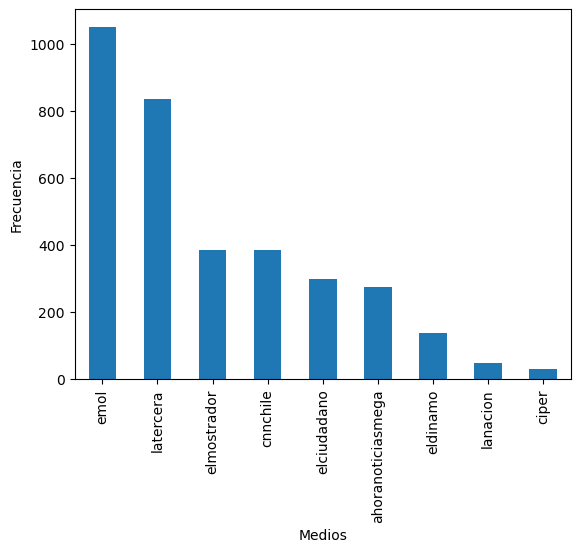

In [391]:
# Obtenemos la cantidad de noticias sobre incendio que publica cada medio y gráficamos
media_count = dataset['media_outlet'].value_counts()
media_count.plot(kind = 'bar',xlabel='Medios',ylabel='Frecuencia')

Text(0.5, 1.0, 'Cantidad de Noticias Publicadas por Año')

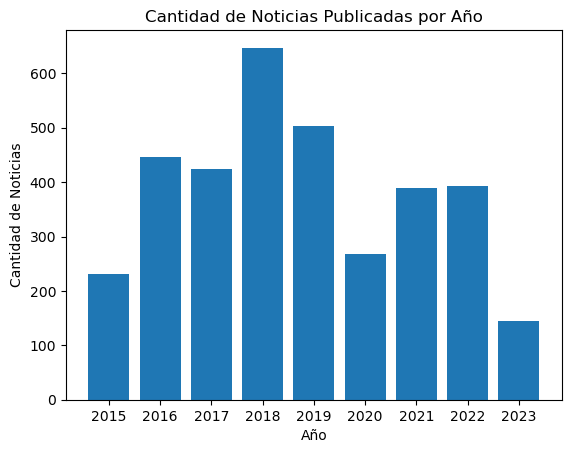

In [392]:
# Obtener el año de cada fecha
dataset['Año'] = dataset['date'].dt.year

# Contar la cantidad de noticias por año
conteo_noticias = dataset['Año'].value_counts().sort_index()

# Configuración del gráfico de barras
plt.bar(conteo_noticias.index, conteo_noticias.values)
plt.xlabel("Año")
plt.ylabel("Cantidad de Noticias")
plt.xticks(conteo_noticias.index, conteo_noticias.index)
plt.title("Cantidad de Noticias Publicadas por Año")

In [393]:
## Lista de países
df_paises = pd.read_csv('paises.csv')
paises= df_paises['Pais'].tolist()
paises[0:5]

['Afganistán', 'Albania', 'Alemania', 'Andorra', 'Angola']

In [394]:
# Lista de gentilicios
df_gentilicios = pd.read_csv('Gentilicios.csv')
gentilicios = df_gentilicios['Gentilicios'].tolist()
gentilicios[0:5]

['afgano', 'albanés', 'alemán', 'andorrano', 'angoleño']

In [395]:
#Lista de Gentilicios en Plural
df_gentilicios_plural = pd.read_csv('Gentilicios_plural.csv')
gentilicios_plural = df_gentilicios_plural['Gentilicios_plural'].tolist()
gentilicios_plural[0:5]

['afganos', 'albaneses', 'alemanes', 'andorranos', 'angoleños']

In [396]:
# Diccionario de Gentilicio y País
with open('gentilicios_dic.pkl', 'rb') as file:
    gentilicios_dic = pickle.load(file)
gentilicios_dicc = {valor: clave for clave, valor in gentilicios_dic.items()}
dict(list(gentilicios_dicc.items())[:5])

{'afgano': 'Afganistán',
 'albanés': 'Albania',
 'alemán': 'Alemania',
 'andorrano': 'Andorra',
 'angoleño': 'Angola'}

In [397]:
# Diccionario de Gentilicio en Plural y País
with open('gentilicios_dic_plural.pkl', 'rb') as file:
    gentilicios_dic_plural = pickle.load(file)
gentilicios_dicc_plural = {valor: clave for clave, valor in gentilicios_dic_plural.items()}
dict(list(gentilicios_dicc_plural.items())[:5])

{'afganos': 'Afganistán',
 'albaneses': 'Albania',
 'alemanes': 'Alemania',
 'andorranos': 'Andorra',
 'angoleños': 'Angola'}

In [398]:
#Función para buscar palabras dentro del Dataset
def buscar_palabras(dataset, palabras):
    palabras_encontradas = []
    for fila in dataset['text']:
        palabras_fila = []
        for palabra in palabras:
            if palabra in fila:
                palabras_fila.append(palabra)
        palabras_encontradas.append(palabras_fila)
    return palabras_encontradas


#Aplicamos la función con nuestros en nuestros datos con los países, gentilicios y  gentilicios en plural
paises_data = buscar_palabras(dataset, paises)
gentilicios_data = buscar_palabras(dataset, gentilicios)
gentilicios_plural_data = buscar_palabras(dataset,gentilicios_plural)

In [399]:
## Utilizamos el diccionario para convertir nuestros datos de gentilicios y gentilicios en plural a países
gentilicios = [[gentilicios_dicc.get(valor, valor) for valor in sublista] for sublista in gentilicios_data]
gentilicios_plural = [[gentilicios_dicc_plural.get(valor, valor) for valor in sublista] for sublista in gentilicios_plural_data]

In [400]:
## Convertirmos nuestros países encontrados a una lista con filas, borrando duplicados
paises_unicos = []
for elemento1, elemento2, elemento3 in zip(paises_data,gentilicios,gentilicios_plural):
    fila = [elemento1, elemento2, elemento3]
    fila_plana=sum(fila, [])
    paises_unicos.append((sorted(set(fila_plana))))
    
paises_unicos[0:5]

[['Chile'],
 ['Chile'],
 ['Chile'],
 ['Estados Unidos', 'Venezuela'],
 ['Estados Unidos']]

In [401]:
## Agregamos nuestra lista de países al dataset
dataset['pais'] = paises_unicos

## Mantenemos las filas que tengas mas de un país en la columnas de los países
dataset = dataset[dataset['pais'].apply(lambda x: len(x) > 1)]

## Filtramos la fecha desde el 2016 al 2021
dataset = dataset[(dataset['date'].dt.year >=2016) & (dataset['date'].dt.year<=2021)]

## Creamos un nuevo dataframe que tendrá solo la columna del id de la noticia y los países mencionados
df_network = dataset[['id_news','pais']]

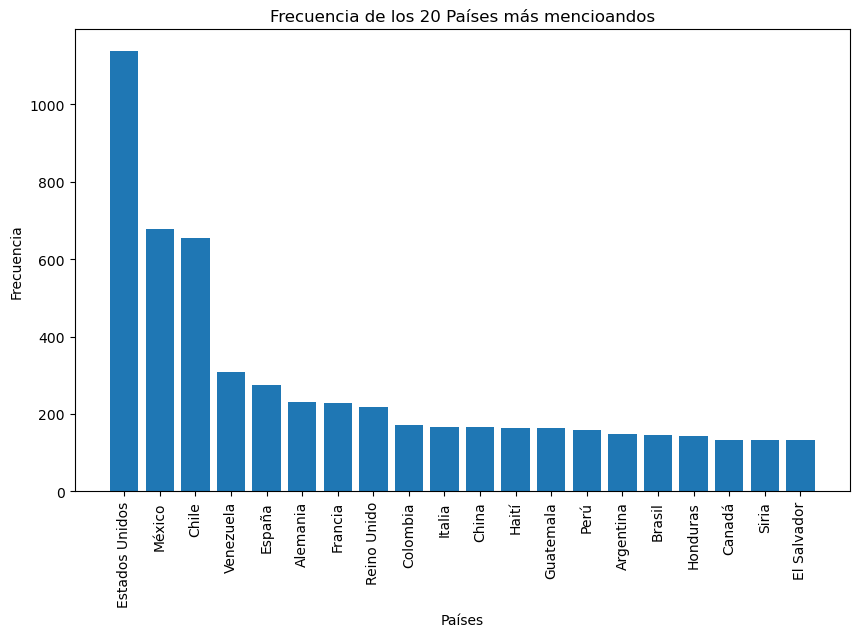

In [402]:
##Vemos cuales son los 20 países mas mencionados

flat_GEO = [item for sublist in df_network['pais'].tolist() for item in sublist]
word_count = Counter(flat_GEO)

words = []
frequencies = []
top_n = 20 

for word, frequency in word_count.most_common(top_n):
    words.append(word)
    frequencies.append(frequency)

plt.figure(figsize=(10, 6))
plt.bar(words, frequencies)
plt.xlabel('Países')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de los {} Países más mencioandos'.format(top_n))
plt.xticks(rotation=90)
plt.savefig('paises_noticias.png', dpi=300, bbox_inches='tight')

In [403]:
## Obtenemos las coordenada de cada país mecionados
paises_location = np.unique([item for sublist in paises_unicos for item in sublist])
geolocator = Nominatim(user_agent="my_app", timeout=10)
coordenadas = {}
for pais in paises_location:
    location = geolocator.geocode(pais)
    coordenadas[pais] = (location.latitude, location.longitude)
  

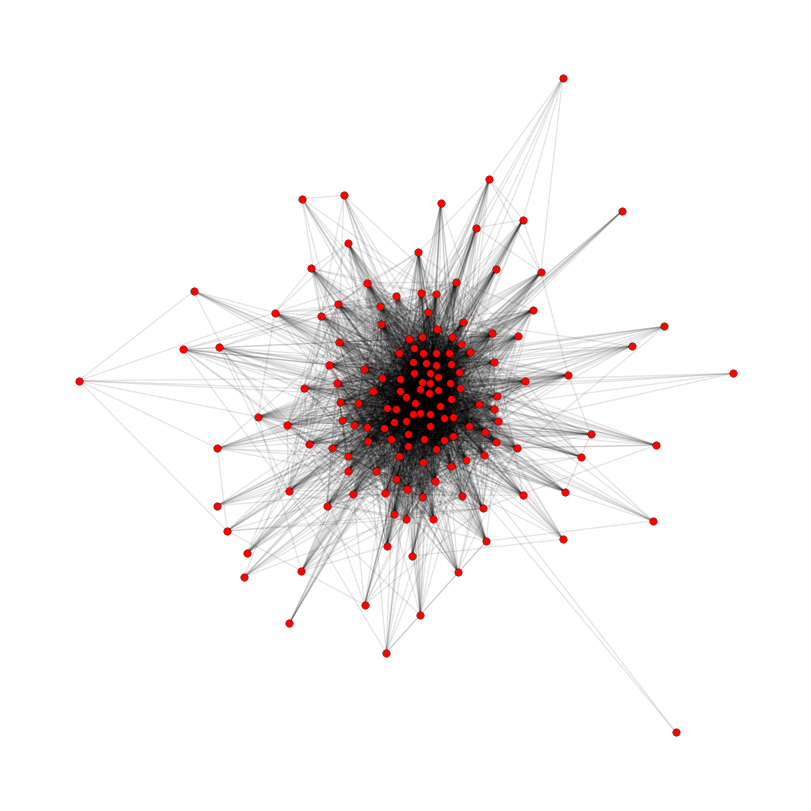

In [404]:
##Creamos un grafo donde los nodos correspondes a los países y las conexiones existirá si 
## dos o mas países son mencionados en la misma noticia. Tambien el "peso" de la conexión será mayor si son 
## mencionados mas de una vez

G = nx.Graph()

for _, row in df_network.iterrows():
    paises = row['pais']
    for i in range(len(paises)):
        for j in range(i + 1, len(paises)):
            peso = G.get_edge_data(paises[i], paises[j], default={'weight': 0})['weight'] + 1
            G.add_edge(paises[i], paises[j], weight=peso)
            
## Normalizamos el tamaño de los pesos           
labels = nx.get_edge_attributes(G,'weight')    
weights = list(labels.values())
max_weight = max(weights)    
normalized_weights = [(weight / max_weight)+1 for weight in weights]

## Gráficamos los nodos y las conexiones
fig, axs = plt.subplots(figsize=(8,8), facecolor='w', nrows=1, ncols=1, constrained_layout=True)
pos = nx.layout.circular_layout(G)
pos = nx.spring_layout(G, pos=pos, k=0.7, iterations=100, seed=0)
sc = nx.draw_networkx_nodes(G, pos, linewidths=0.2, node_color='red', edgecolors='black', ax=axs, node_size=30)
nx.draw_networkx_edges(G, pos, width=normalized_weights, ax=axs,alpha=0.1)
axs.axis('off')
plt.savefig('paises_grafos.png', dpi=300, bbox_inches='tight')

Una vez construido el grafo principal, se identificaron los pares de países que se encuentran a menos de 5000 kilómetros de distancia y que tenían una conexión con un peso mayor a 5. Estos pares formaron un nuevo grafo, el cual se visualizó en un mapa del planeta. 

In [405]:
## Creamos un nuevo grafo
G_map = nx.Graph()

# Guardamos los paises mencionaods
pais_location = []

#Extramos los pesos del grafo anterior
weights = nx.get_edge_attributes(G, "weight")

##Obtenemos las conexiones
edges = heapq.nlargest(5000, weights.items(), key=lambda x: x[1])

## Caculamos el promedio de los pesos y la media
prom_weight = np.mean([weight for edge, weight in edges])
median_weight = np.median([weight for edge, weight in edges])

#Filtramos los países que tengan una distancia menos a 5000kilometros y tengan un peso mayor a 5
for edge, weight in edges:
    pais1, pais2 = edge
    distancia = geodesic((coordenadas[pais2][0], coordenadas[pais2][1]), (coordenadas[pais1][0], coordenadas[pais1][1])).kilometers
    if distancia < 5000 and weight>5 :
        G_map.add_edge(pais1, pais2, weight=weight)
        pais_location.append([pais1,pais2])


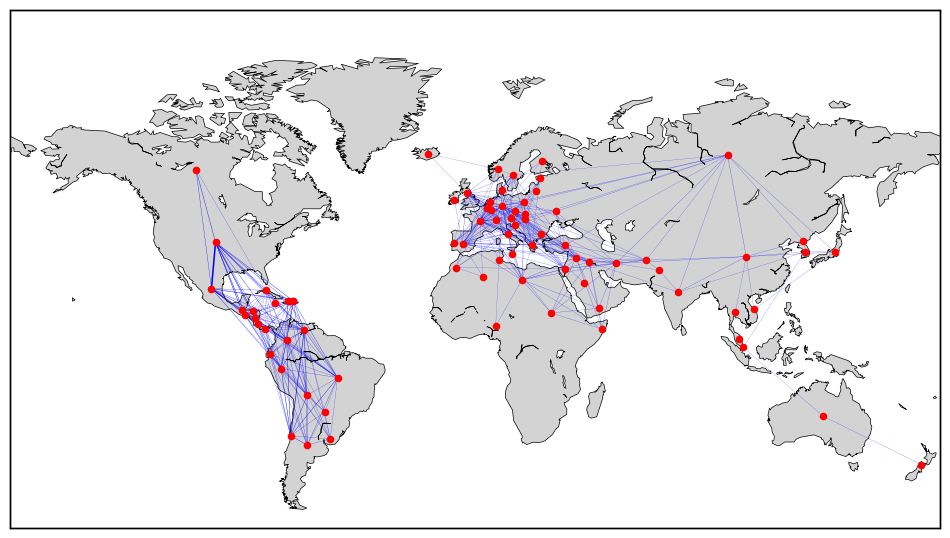

In [406]:
## Mostramos el  nuevo grafo en un mapa del planeta

# Creamos una Figura
fig = plt.figure(figsize=(12, 8))

# Marcamos los limites de latitud y longitud y desiganmos colores para el mar los lagos y los continentes.
m = Basemap(projection='mill', llcrnrlat=-60, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')
m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='lightgray', lake_color='white')
m.drawmapboundary(fill_color='white')

# Designamos las posiciones de los nodos (países) segun sus coordenandas
pos = {}
for country in coordenadas:
    x, y = m(coordenadas[country][1], coordenadas[country][0])
    pos[country] = (x, y)

## Normalizamos los pesos
labels = nx.get_edge_attributes(G_map,'weight')   
weights = list(labels.values())
max_weight = max(weights)    
normalized_weights = [(weight / max_weight)+0.1 for weight in weights]

# Creamos los nodos y las conexiones
nx.draw_networkx_edges(G_map, pos, width=normalized_weights, alpha=1, edge_color='b', arrows=False)
nx.draw_networkx_nodes(G_map, pos, node_color='red',node_size=20)

#plt.title("Grafo de Conexiones en un Mapa del Planeta")
plt.savefig('paises_grafos2.png', dpi=300, bbox_inches='tight')

In [407]:
# Ocupamos el algoritmo Louvain Community Detection Algorithm para detectar las comunidades
comunidades = nx.community.louvain_communities(G_map, seed=123)
grupos = {}

for i, comunidad in enumerate(comunidades):
    for nodo in comunidad:
        grupos[nodo] = i

# Guardamos los subgrafos creados a partir del algoritmo
subgrafos = []
for comunidad in comunidades:
    subgrafo = G_map.subgraph(comunidad)
    subgrafos.append(subgrafo)

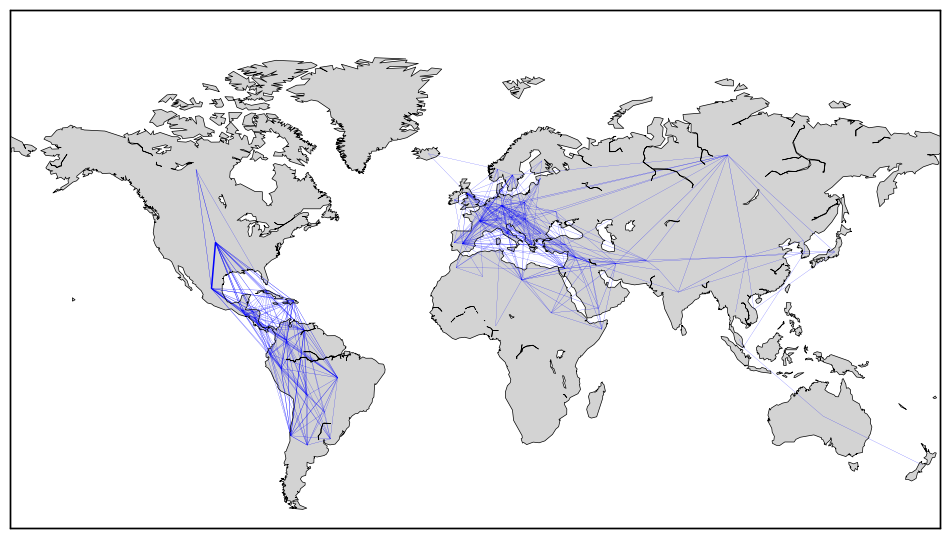

In [408]:
## Ahora similar al mapa anterior, visualizamos el grafo pero ahora dividiendo las comunidades por colores

fig = plt.figure(figsize=(12, 8))
m = Basemap(projection='mill', llcrnrlat=-60, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')
m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='lightgray', lake_color='white')
m.drawmapboundary(fill_color='white')

labels = nx.get_edge_attributes(G_map,'weight') 

pos = {}
for country in coordenadas:
    x, y = m(coordenadas[country][1], coordenadas[country][0])
    pos[country] = (x, y)
    
weights = list(labels.values())
max_weight = max(weights)    
normalized_weights = [(weight / max_weight)+0.1 for weight in weights]

nx.draw_networkx_edges(G_map, pos, width=normalized_weights, alpha=1, edge_color='b', arrows=False)
plt.savefig('paises_grafos3.png', dpi=300, bbox_inches='tight')

In [409]:
#Creamos una lista con diferentes colores
colores = ['#FF0000', '#00FF00', '#0000FF', '#FF00FF', '#00FFFF', '#FFFF00', '#FFA500', '#800080',
           '#008000', '#800000', '#FF1493', '#00CED1', '#FF4500', '#7B68EE', '#FFC0CB', '#8A2BE2',
           '#008080', '#FFD700', '#DC143C', '#6A5ACD', '#2E8B57', '#B22222', '#FF69B4', '#4169E1',
           '#FF8C00', '#9932CC', '#8B0000', '#00FA9A', '#ADFF2F', '#4B0082', '#FFB6C1', '#6B8E23',
           '#BA55D3', '#6495ED', '#FF7F50', '#008B8B', '#8B008B', '#FF6347', '#00FF7F', '#DA70D6',
           '#ADFF2F', '#7FFF00', '#FF4500', '#FF8C00', '#FFD700', '#ADFF2F', '#008000', '#006400',
           '#4B0082', '#800080', '#8B008B', '#000080', '#00008B', '#1E90FF', '#00BFFF', '#008080',
           '#00FF7F', '#32CD32', '#9ACD32', '#FF0000', '#FF69B4']

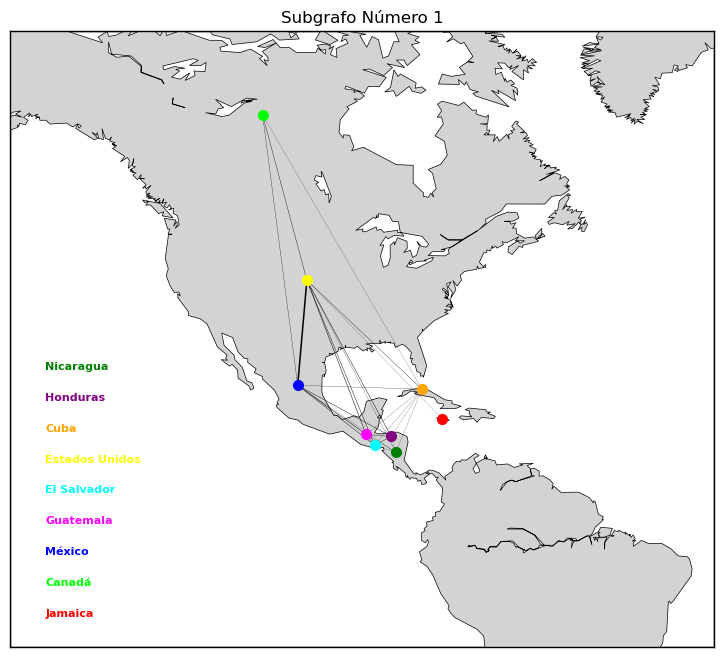

In [410]:
# Ahora visualizamos la comunidad creada en América del Norte y América Central 
fig = plt.figure(figsize=(12, 8))

# Visualizamos la primera componente 
graph = 0

## Calculamos la latitud y longitud promedio de los países en el primero subgrafo
lat_prom = np.mean([coordenadas[country][0] for country in comunidades[graph]])
lon_prom = np.mean([coordenadas[country][1] for country in comunidades[graph]])

## Designamos el lugar que se visualizará en el mapa
delta_lat = 45
delta_lon = 60
m = Basemap(projection='mill', llcrnrlat=lat_prom-delta_lat, urcrnrlat=lat_prom+delta_lat,
            llcrnrlon=lon_prom-delta_lon, urcrnrlon=lon_prom+delta_lon, resolution='c')

m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='lightgray', lake_color='white')
m.drawmapboundary(fill_color='white')

pos = {}
for country ,color in zip(comunidades[graph], colores):
    x, y = m(coordenadas[country][1], coordenadas[country][0])
    pos[country] = (x, y)
    m.plot(x, y, 'o', markersize=7, color=color)  
    
labels = nx.get_edge_attributes(subgrafos[graph], 'weight')
weights = list(labels.values())
max_weight = max(weights)
normalized_weights = [(weight / max_weight)+0.1 for weight in weights]

nx.draw_networkx_edges(subgrafos[graph], pos, width=normalized_weights, alpha=1, edge_color='black', arrows=False)

#Designamos el lugar donde irán las etiquetas
corner_x = 0.05
corner_y = 0.05
offset_x = 0.0
offset_y = 0.05

# Agregar etiquetas de los países en la esquina
for country, color in zip(comunidades[graph], colores):
    x, y = m(coordenadas[country][1], coordenadas[country][0])
    plt.annotate(country, xy=(x, y), xytext=(corner_x, corner_y),
                 textcoords='axes fraction', color=color, fontsize=8, fontweight='bold')
    corner_y += offset_y
    corner_x += offset_x

plt.title("Subgrafo Número 1")
plt.show()


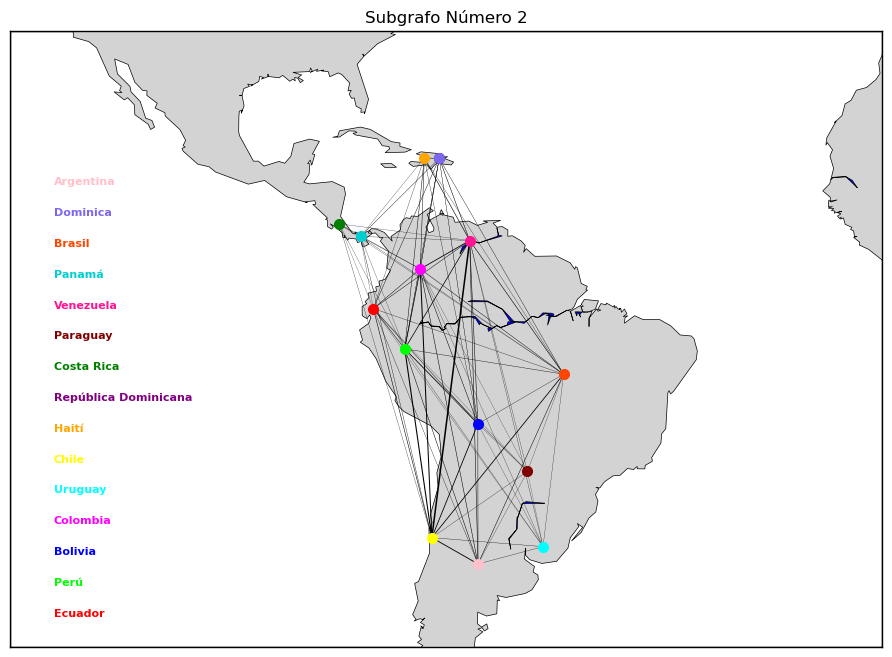

In [411]:
fig = plt.figure(figsize=(12, 8))

graph = 1
lat_prom = np.mean([coordenadas[country][0] for country in comunidades[graph]])
lon_prom = np.mean([coordenadas[country][1] for country in comunidades[graph]])

delta_lat = 40
delta_lon = 60
m = Basemap(projection='mill', llcrnrlat=lat_prom-delta_lat, urcrnrlat=lat_prom+delta_lat,
            llcrnrlon=lon_prom-delta_lon, urcrnrlon=lon_prom+delta_lon, resolution='c')

m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='lightgray', lake_color='blue')
m.drawmapboundary(fill_color='white')

pos = {}
for country ,color in zip(comunidades[graph], colores):
    x, y = m(coordenadas[country][1], coordenadas[country][0])
    pos[country] = (x, y)
    m.plot(x, y, 'o', markersize=7, color=color)  

labels = nx.get_edge_attributes(subgrafos[graph], 'weight')
weights = list(labels.values())
max_weight = max(weights)
normalized_weights = [(weight / max_weight)+0.1 for weight in weights]

nx.draw_networkx_edges(subgrafos[graph], pos, width=normalized_weights, alpha=1, edge_color='black', arrows=False)

corner_x = 0.05
corner_y = 0.05
offset_x = 0.0
offset_y = 0.05

for country, color in zip(comunidades[graph], colores):
    x, y = m(coordenadas[country][1], coordenadas[country][0])
    plt.annotate(country, xy=(x, y), xytext=(corner_x, corner_y),
                 textcoords='axes fraction', color=color, fontsize=8, fontweight='bold')
    corner_y += offset_y
    corner_x += offset_x

plt.title("Subgrafo Número 2")
plt.show()

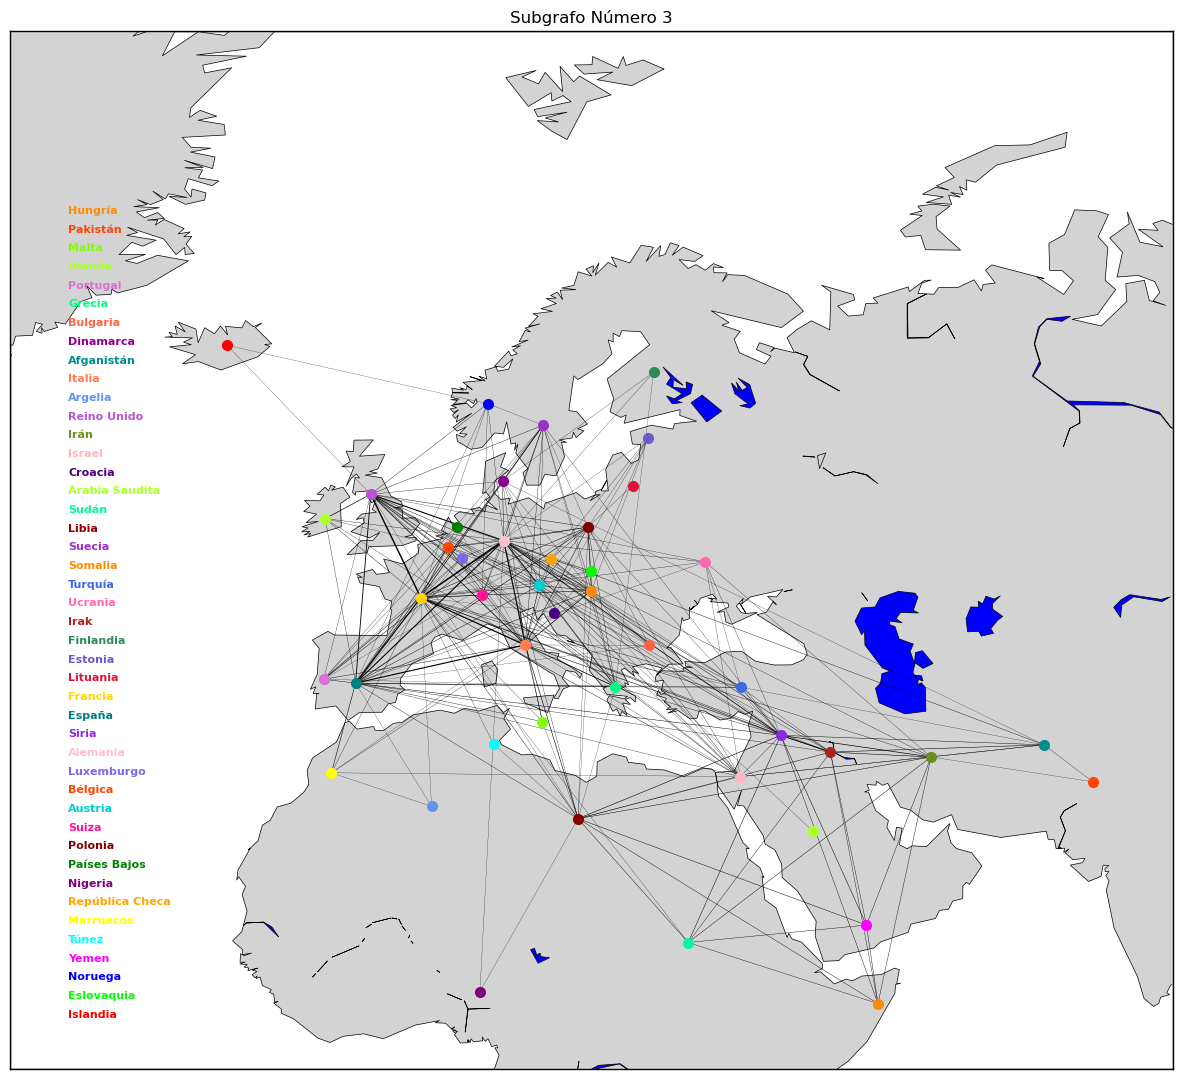

In [412]:
fig = plt.figure(figsize=(15, 15))

graph = 2
lat_prom = np.mean([coordenadas[country][0] for country in comunidades[graph]])
lon_prom = np.mean([coordenadas[country][1] for country in comunidades[graph]])

delta_lat = 40
delta_lon = 60
m = Basemap(projection='mill', llcrnrlat=lat_prom-delta_lat, urcrnrlat=lat_prom+delta_lat,
            llcrnrlon=lon_prom-delta_lon, urcrnrlon=lon_prom+delta_lon, resolution='c')

m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='lightgray', lake_color='blue')
m.drawmapboundary(fill_color='white')

pos = {}
for country ,color in zip(comunidades[graph], colores):
    x, y = m(coordenadas[country][1], coordenadas[country][0])
    pos[country] = (x, y)
    m.plot(x, y, 'o', markersize=7, color=color)  

labels = nx.get_edge_attributes(subgrafos[graph], 'weight')
weights = list(labels.values())
max_weight = max(weights)
normalized_weights = [(weight / max_weight)+0.1 for weight in weights]

nx.draw_networkx_edges(subgrafos[graph], pos, width=normalized_weights, alpha=1, edge_color='black', arrows=False)

corner_x = 0.05
corner_y = 0.05
offset_x = 0.0
offset_y = 0.018


for country, color in zip(comunidades[graph], colores):
    x, y = m(coordenadas[country][1], coordenadas[country][0])
    plt.annotate(country, xy=(x, y), xytext=(corner_x, corner_y),
                 textcoords='axes fraction', color=color, fontsize=8, fontweight='bold')
    corner_y += offset_y
    corner_x += offset_x

plt.title("Subgrafo Número 3")
plt.show()

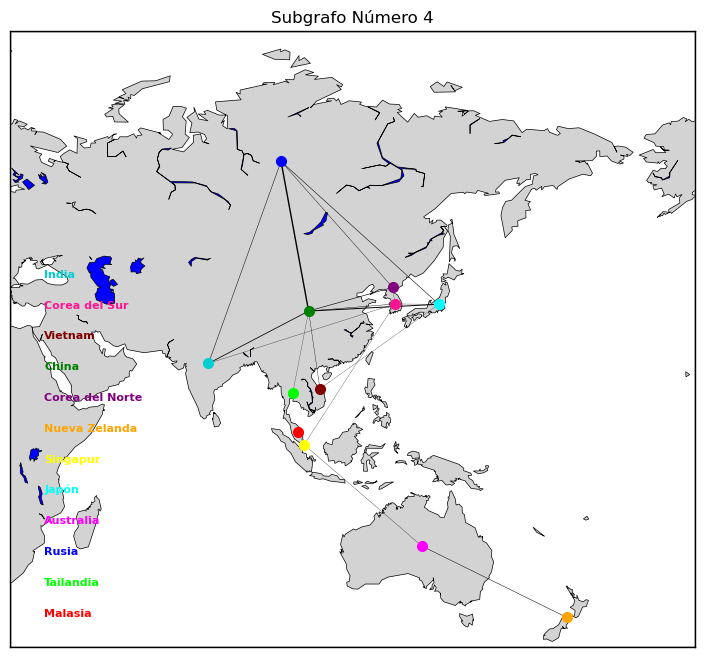

In [413]:
fig = plt.figure(figsize=(12, 8))


graph = 3
lat_prom = np.mean([coordenadas[country][0] for country in comunidades[graph]])
lon_prom = np.mean([coordenadas[country][1] for country in comunidades[graph]])

delta_lat = 65
delta_lon = 90
m = Basemap(projection='mill', llcrnrlat=lat_prom-delta_lat, urcrnrlat=lat_prom+delta_lat,
            llcrnrlon=lon_prom-delta_lon, urcrnrlon=lon_prom+delta_lon, resolution='c')

m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='lightgray', lake_color='blue')
m.drawmapboundary(fill_color='white')

pos = {}
for country ,color in zip(comunidades[graph], colores):
    x, y = m(coordenadas[country][1], coordenadas[country][0])
    pos[country] = (x, y)
    m.plot(x, y, 'o', markersize=7, color=color)  
    
labels = nx.get_edge_attributes(subgrafos[graph], 'weight')
weights = list(labels.values())
max_weight = max(weights)
normalized_weights = [weight / max_weight for weight in weights]

nx.draw_networkx_edges(subgrafos[graph], pos, width=normalized_weights, alpha=1, edge_color='black', arrows=False)

corner_x = 0.05
corner_y = 0.05
offset_x = 0.0
offset_y = 0.05


for country, color in zip(comunidades[graph], colores):
    x, y = m(coordenadas[country][1], coordenadas[country][0])
    plt.annotate(country, xy=(x, y), xytext=(corner_x, corner_y),
                 textcoords='axes fraction', color=color, fontsize=8, fontweight='bold')
    corner_y += offset_y
    corner_x += offset_x

plt.title("Subgrafo Número 4")
plt.show()

## A continuación, se estudiaron los subgrafos en función del tiempo, específicamente entre 2016 y 2021. Se analizó cómo evolucionaron estas comunidades, identificando los países que se agregaron y los que se eliminaron de cada subgrafo.

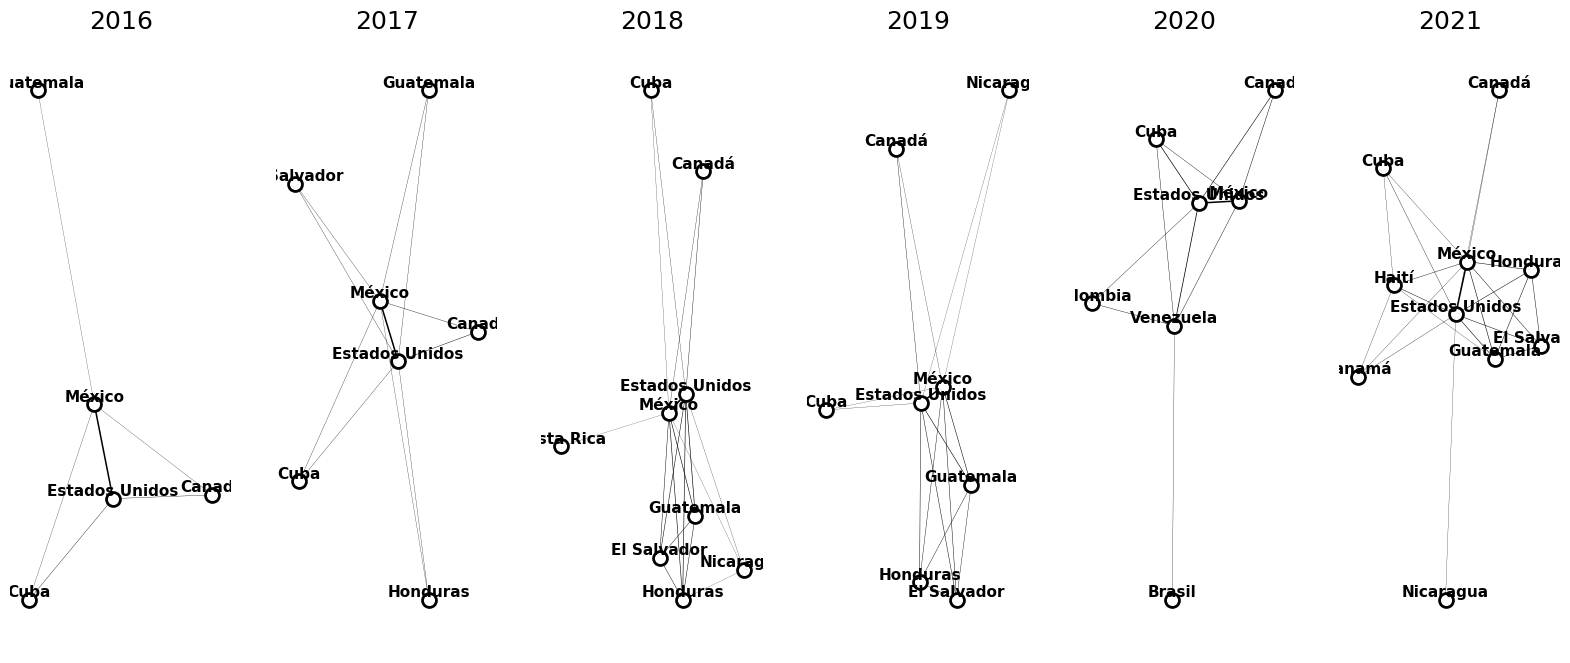

In [429]:
## Guardamos los países para realizar una matriz de aparación por año
paises_matrix = []
## Guardamos los dataframes para realizar mostrar el eigenvector centrality de cada país por año
df_append= []
fig, axs = plt.subplots(figsize=(20,8), facecolor="w", nrows=1, ncols=6)
k = 0

## Iteramos cada año
for year in range(2016,2022):
    
    ## A partir del data set creeado en el inicio, filtramos los años
    df_date = dataset[dataset['date'].dt.year == year][['id_news','pais']]
    
    # Creamos un grafo con los datos de un determinado año
    G = nx.Graph()

    for _, row in df_date.iterrows():
        paises = row['pais']
        for i in range(len(paises)):
            for j in range(i + 1, len(paises)):
                peso = G.get_edge_data(paises[i], paises[j], default={'weight': 0})['weight'] + 1
                G.add_edge(paises[i], paises[j], weight=peso)
     
    # Filtramos a países que se encuentren a menos de 500 kilimetros de distancia y que tengan un peso mayor a 5
    G_map = nx.Graph()
    weights = nx.get_edge_attributes(G, "weight")
    edges = heapq.nlargest(5000, weights.items(), key=lambda x: x[1])
    for edge, weight in edges:
        pais1, pais2 = edge
        distancia = geodesic((coordenadas[pais2][0], coordenadas[pais2][1]), (coordenadas[pais1][0], coordenadas[pais1][1])).kilometers
    
        if distancia < 5000 and weight>5 :
            G_map.add_edge(pais1, pais2, weight=weight)
            
    # Obtenemos las comunidades        
    comunidades = nx.community.louvain_communities(G_map, seed=123)
    
    grupos = {}

    for i, comunidad in enumerate(comunidades):
        for nodo in comunidad:
            grupos[nodo] = i
        
    subgrafos = []
    for comunidad in comunidades:
        subgrafo = G_map.subgraph(comunidad)
        subgrafos.append(subgrafo)
        
    #Selecionamos la primera componente    
    graph = 0
    paises_matrix.append(comunidades[graph])
    pos = nx.layout.circular_layout(subgrafos[graph])
    pos = nx.spring_layout(subgrafos[graph], pos=pos, k=0.7, iterations=200, seed=0)
    
    
    nx.draw_networkx_nodes(subgrafos[graph], pos, node_color='white', linewidths=2, 
      edgecolors='k', ax=axs[k], node_size=100)
    labels = nx.get_edge_attributes(subgrafos[graph], 'weight')
    weights = list(labels.values())
    normalized_weights = [(weight /  max(weights))+0.1 for weight in weights]
    nx.draw_networkx_edges(subgrafos[graph], pos, width=normalized_weights, ax=axs[k])
  
    nx.draw_networkx_labels(subgrafos[graph], pos, font_size=11, font_weight='bold',verticalalignment='bottom', ax=axs[k])
    axs[k].spines[['left', 'right', 'top', 'bottom']].set_visible(False)
    axs[k].set_title("${%i}$" % (year), fontsize=18)
    
    k = k+1
    
    #Calculamos el eigenvetor centrality de cada país en cada año
    eigenvector_centrality = nx.eigenvector_centrality(subgrafos[graph])
    df = pd.DataFrame(list(eigenvector_centrality.items()), columns=['País', '{}'.format(year)])
    df_append.append(df)

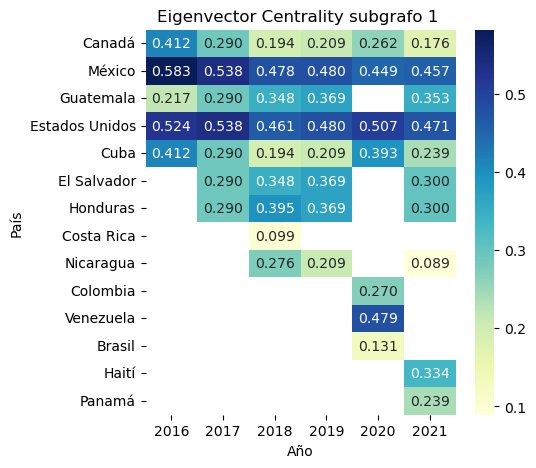

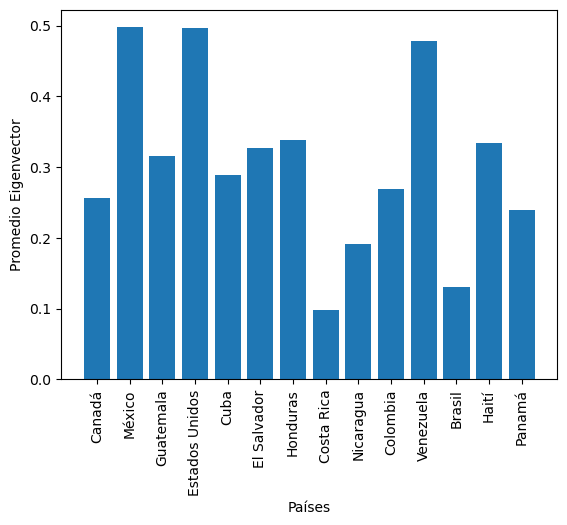

In [430]:
# Ahora creamos una matriz con el valor de eigenvetor centrality de cada país en cada año, si no aparece el 
# quiere decir que el país no aparece en el subgrafo
df_concatenado = pd.DataFrame(columns=['País'])
df_concatenado = df_concatenado.set_index('País')

# Concatenar los dataframes por columna 'País'
for df in df_append:
    df_concatenado = pd.concat([df_concatenado, df.set_index('País')], axis=1)

plt.figure(figsize=(5, 5))  
sns.heatmap(df_concatenado, cmap='YlGnBu', annot=True, fmt=".3f")  
plt.title('Eigenvector Centrality subgrafo 1 ')
plt.xlabel('Año')
plt.ylabel('País')
plt.show()

plt.bar(df_concatenado.index,df_concatenado.mean(axis=1))
plt.xlabel('Países')
plt.ylabel('Promedio Eigenvector')
plt.xticks(rotation=90)
plt.show()

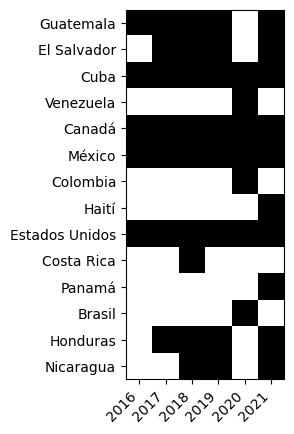

In [431]:
# Ahora realizamos una matriz de aparición de países en cada año  (negro:presente, blanco:ausente)
datos = paises_matrix
paises_unicos = list(set.union(*datos))
anios = list(range(2016, 2022))
matriz = [[0] * len(anios) for _ in range(len(paises_unicos))]
for i, year_data in enumerate(datos):
    for j, pais in enumerate(paises_unicos):
        if pais in year_data:
            matriz[j][i] = 1

fig, ax = plt.subplots()
im = ax.imshow(matriz, cmap='binary')
ax.set_xticks(range(len(anios)))
ax.set_yticks(range(len(paises_unicos)))
ax.set_xticklabels(anios)
ax.set_yticklabels(paises_unicos)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.savefig('subgrafo1.png', dpi=300, bbox_inches='tight')

## Los demas subragfos se estudiaron de la misma manera que el anterior

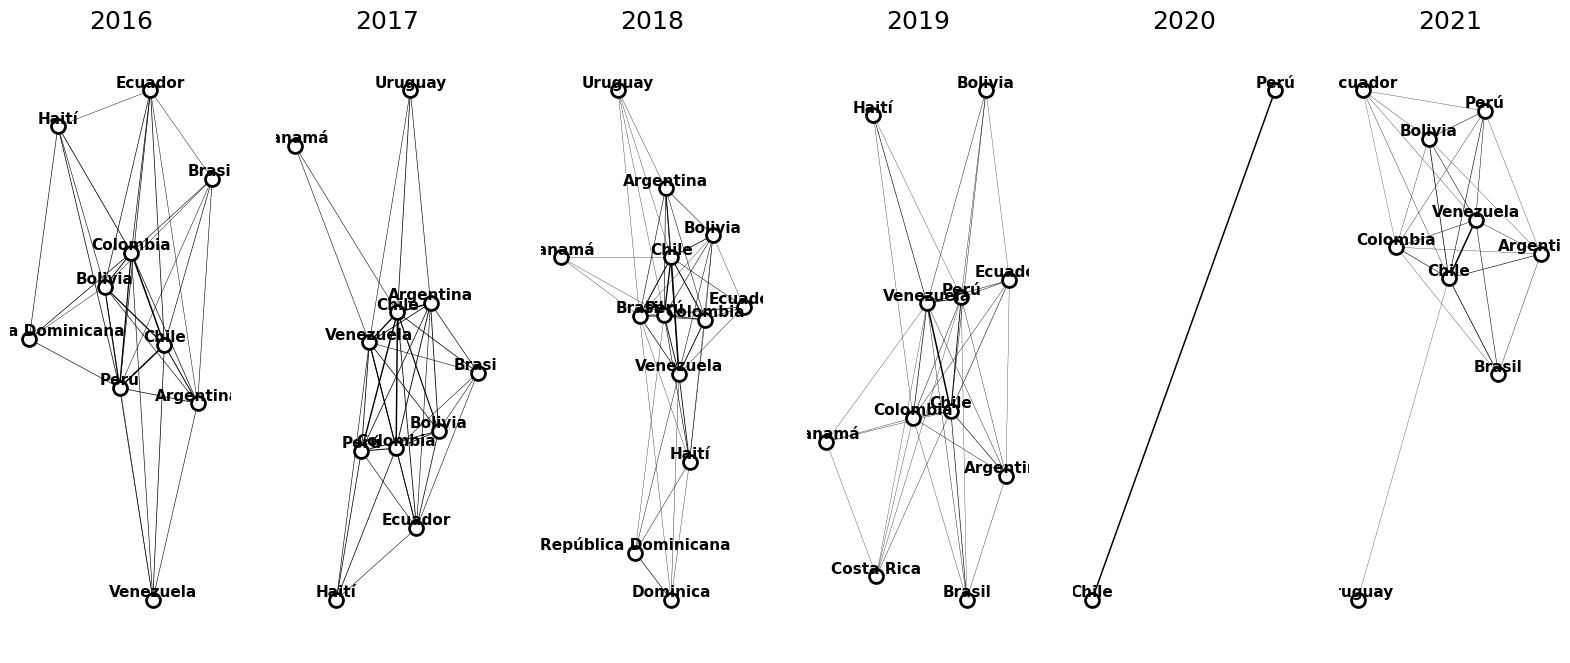

In [432]:
fig, axs = plt.subplots(figsize=(20,8), facecolor="w", nrows=1, ncols=6)
paises_matrix = []
df_append= []
k = 0
for year in range(2016,2022):
    
    df_date = dataset[dataset['date'].dt.year == year][['id_news','pais']]
    G = nx.Graph()

    for _, row in df_date.iterrows():
        paises = row['pais']
        for i in range(len(paises)):
            for j in range(i + 1, len(paises)):
                peso = G.get_edge_data(paises[i], paises[j], default={'weight': 0})['weight'] + 1
                G.add_edge(paises[i], paises[j], weight=peso)
                
    G_map = nx.Graph()
    weights = nx.get_edge_attributes(G, "weight")

    edges = heapq.nlargest(1000, weights.items(), key=lambda x: x[1])
    for edge, weight in edges:
        pais1, pais2 = edge
        distancia = geodesic((coordenadas[pais2][0], coordenadas[pais2][1]), (coordenadas[pais1][0], coordenadas[pais1][1])).kilometers
        if distancia < 5000 and weight>5 :
            G_map.add_edge(pais1, pais2, weight=weight)
 
    comunidades = nx.community.louvain_communities(G_map, seed=123)
    grupos = {}

    for i, comunidad in enumerate(comunidades):
        for nodo in comunidad:
            grupos[nodo] = i
        
    subgrafos = []
    for comunidad in comunidades:
        subgrafo = G_map.subgraph(comunidad)
        subgrafos.append(subgrafo)
        
    graph = 1
    if year == 2018:
        graph = 2
    paises_matrix.append(comunidades[graph])
    
    pos = nx.layout.circular_layout(subgrafos[graph])
    pos = nx.spring_layout(subgrafos[graph], pos=pos, k=0.7, iterations=200, seed=0)
    nx.draw_networkx_nodes(subgrafos[graph], pos, node_color='white', linewidths=2, 
      edgecolors='k', ax=axs[k], node_size=100)
    labels = nx.get_edge_attributes(subgrafos[graph], 'weight')
    weights = list(labels.values())
    normalized_weights = [(weight /  max(weights))+0.1 for weight in weights]
    nx.draw_networkx_edges(subgrafos[graph], pos, width=normalized_weights, ax=axs[k])
  
    nx.draw_networkx_labels(subgrafos[graph], pos, font_size=11, font_weight='bold',verticalalignment='bottom', ax=axs[k])
    axs[k].spines[['left', 'right', 'top', 'bottom']].set_visible(False)
    axs[k].set_title("${%i}$" % (year), fontsize=18)
    k = k+1
    eigenvector_centrality = nx.eigenvector_centrality(subgrafos[graph])
    df = pd.DataFrame(list(eigenvector_centrality.items()), columns=['País', '{}'.format(year)])
    df_append.append(df)

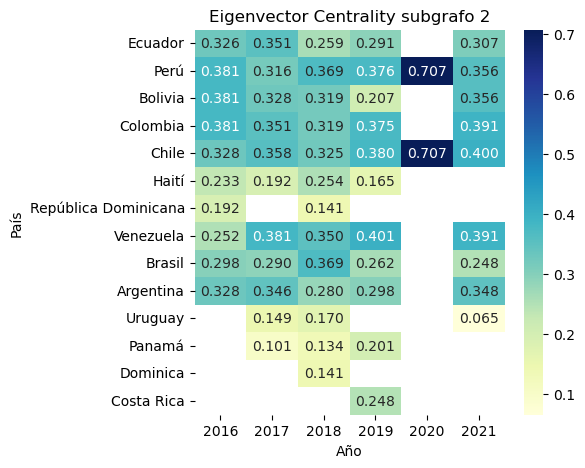

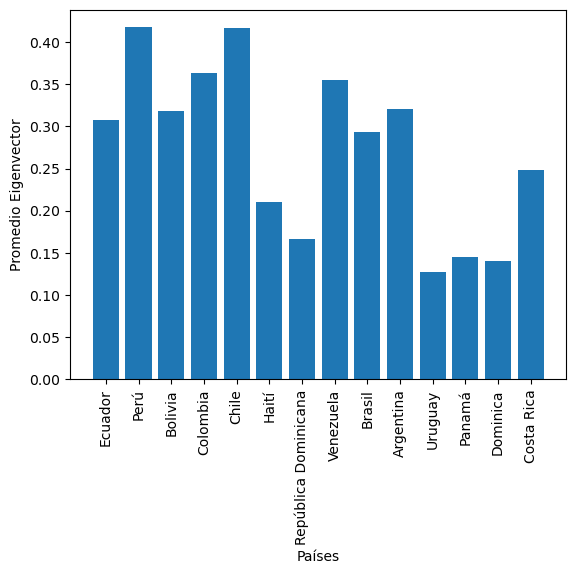

In [433]:
df_concatenado = pd.DataFrame(columns=['País'])
df_concatenado = df_concatenado.set_index('País')

for df in df_append:
    df_concatenado = pd.concat([df_concatenado, df.set_index('País')], axis=1)

plt.figure(figsize=(5, 5))  
sns.heatmap(df_concatenado, cmap='YlGnBu', annot=True, fmt=".3f")

plt.title('Eigenvector Centrality subgrafo 2')
plt.xlabel('Año')
plt.ylabel('País')
plt.show()


plt.bar(df_concatenado.index,df_concatenado.mean(axis=1))
plt.xlabel('Países')
plt.ylabel('Promedio Eigenvector')
plt.xticks(rotation=90)
plt.show()

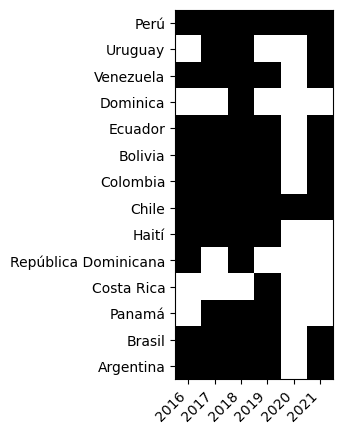

In [434]:
datos = paises_matrix
paises_unicos = list(set.union(*datos))
anios = list(range(2016, 2022))
matriz = [[0] * len(anios) for _ in range(len(paises_unicos))]
for i, year_data in enumerate(datos):
    for j, pais in enumerate(paises_unicos):
        if pais in year_data:
            matriz[j][i] = 1

fig, ax = plt.subplots()
im = ax.imshow(matriz, cmap='binary')
ax.set_xticks(range(len(anios)))
ax.set_yticks(range(len(paises_unicos)))
ax.set_xticklabels(anios)
ax.set_yticklabels(paises_unicos)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.savefig('subgrafo2.png', dpi=300, bbox_inches='tight')

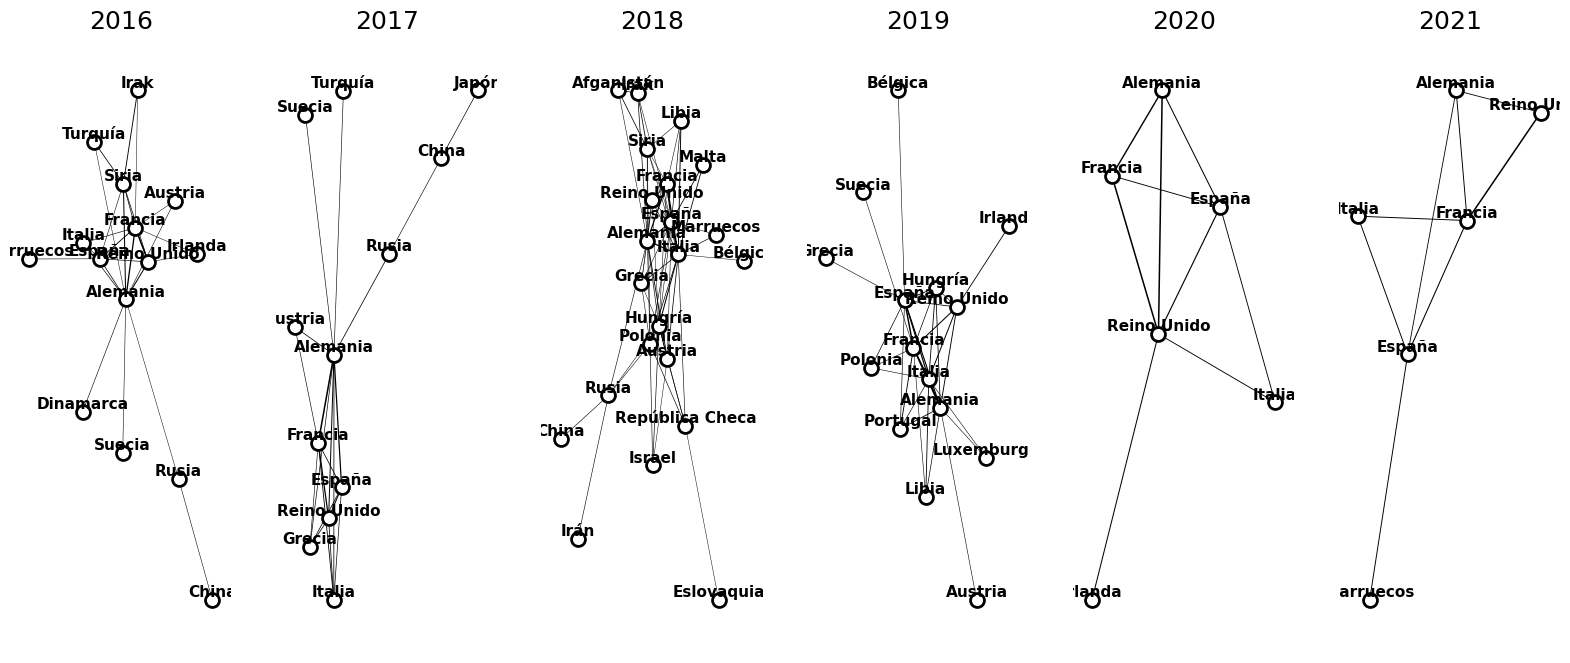

In [445]:
fig, axs = plt.subplots(figsize=(20,8), facecolor="w", nrows=1, ncols=6)
paises_matrix = []
df_append= []
k = 0
for year in range(2016,2022):
    
    df_date = dataset[dataset['date'].dt.year == year][['id_news','pais']]
    G = nx.Graph()

    for _, row in df_date.iterrows():
        paises = row['pais']
        for i in range(len(paises)):
            for j in range(i + 1, len(paises)):
                peso = G.get_edge_data(paises[i], paises[j], default={'weight': 0})['weight'] + 1
                G.add_edge(paises[i], paises[j], weight=peso)
                
    G_map = nx.Graph()
    weights = nx.get_edge_attributes(G, "weight")
    edges = heapq.nlargest(5000, weights.items(), key=lambda x: x[1])
    for edge, weight in edges:
        pais1, pais2 = edge
        distancia = geodesic((coordenadas[pais2][0], coordenadas[pais2][1]), (coordenadas[pais1][0], coordenadas[pais1][1])).kilometers
    
        if distancia < 5000 and weight>5 :
            G_map.add_edge(pais1, pais2, weight=weight)
   
    comunidades = nx.community.louvain_communities(G_map, seed=123)
    grupos = {}

    for i, comunidad in enumerate(comunidades):
        for nodo in comunidad:
            grupos[nodo] = i
        
    subgrafos = []
    for comunidad in comunidades:
        subgrafo = G_map.subgraph(comunidad)
        subgrafos.append(subgrafo)
        
    graph = 3
    if year == 2018:
        graph = 1
    
    if year == 2016:
        graph = 2
    if year == 2019:
        graph = 2
        
    if year == 2021:
        graph = 2
        
    paises_matrix.append(comunidades[graph])
    
    pos = nx.layout.circular_layout(subgrafos[graph])
    pos = nx.spring_layout(subgrafos[graph], pos=pos, k=0.7, iterations=300, seed=0)
    nx.draw_networkx_nodes(subgrafos[graph], pos, node_color='white', linewidths=2, 
      edgecolors='k', ax=axs[k], node_size=100)
    labels = nx.get_edge_attributes(subgrafos[graph], 'weight')
    weights = list(labels.values())
    normalized_weights = [(weight /  max(weights))+0.1 for weight in weights]
    nx.draw_networkx_edges(subgrafos[graph], pos, width=normalized_weights, ax=axs[k])
    nx.draw_networkx_labels(subgrafos[graph], pos, font_size=11, font_weight='bold',verticalalignment='bottom', ax=axs[k])
    axs[k].spines[['left', 'right', 'top', 'bottom']].set_visible(False)
    axs[k].set_title("${%i}$" % (year), fontsize=18)
    k = k+1
    eigenvector_centrality = nx.eigenvector_centrality(subgrafos[graph])
    df = pd.DataFrame(list(eigenvector_centrality.items()), columns=['País', '{}'.format(year)])
    df_append.append(df)

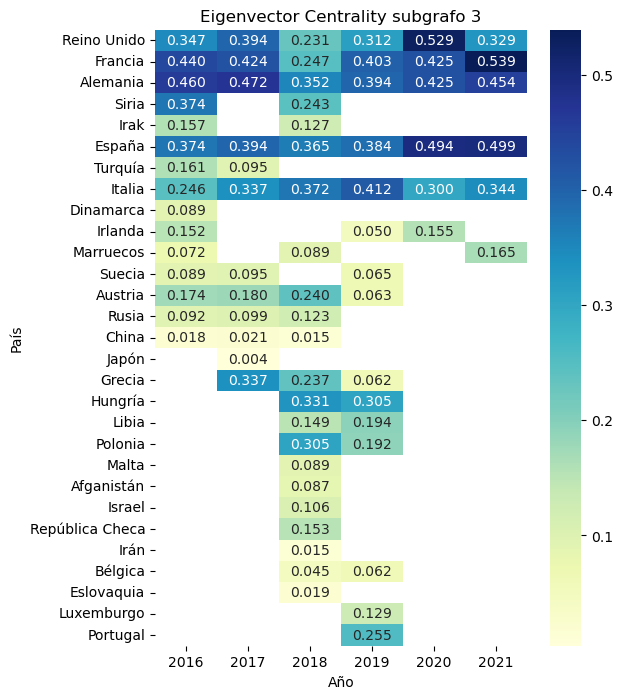

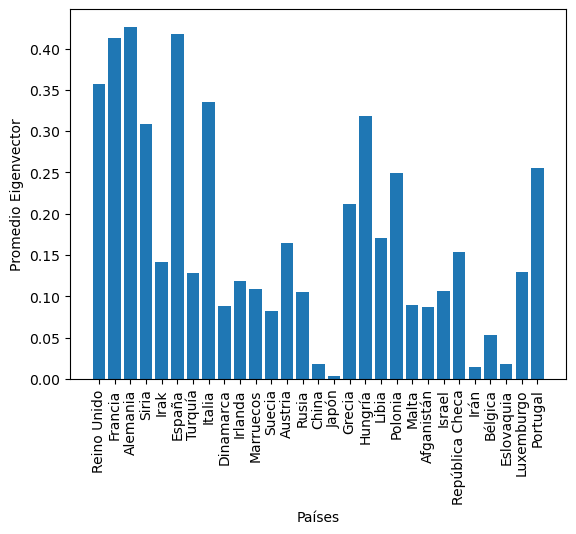

In [446]:
df_concatenado = pd.DataFrame(columns=['País'])
df_concatenado = df_concatenado.set_index('País')

for df in df_append:
    df_concatenado = pd.concat([df_concatenado, df.set_index('País')], axis=1)

plt.figure(figsize=(6, 8))  
sns.heatmap(df_concatenado, cmap='YlGnBu', annot=True, fmt=".3f")

plt.title('Eigenvector Centrality subgrafo 3')
plt.xlabel('Año')
plt.ylabel('País')
plt.show()

plt.bar(df_concatenado.index,df_concatenado.mean(axis=1))
plt.xlabel('Países')
plt.ylabel('Promedio Eigenvector')
plt.xticks(rotation=90)
plt.show()

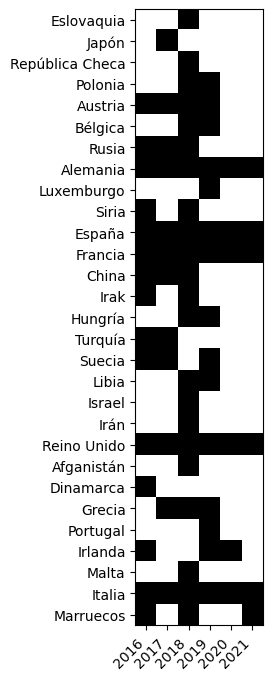

In [447]:
datos = paises_matrix
paises_unicos = list(set.union(*datos))
anios = list(range(2016, 2022))
matriz = [[0] * len(anios) for _ in range(len(paises_unicos))]
for i, year_data in enumerate(datos):
    for j, pais in enumerate(paises_unicos):
        if pais in year_data:
            matriz[j][i] = 1

fig, ax = plt.subplots(figsize=(4, 8))
im = ax.imshow(matriz, cmap='binary')
ax.set_xticks(range(len(anios)))
ax.set_yticks(range(len(paises_unicos)))
ax.set_xticklabels(anios)
ax.set_yticklabels(paises_unicos)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()

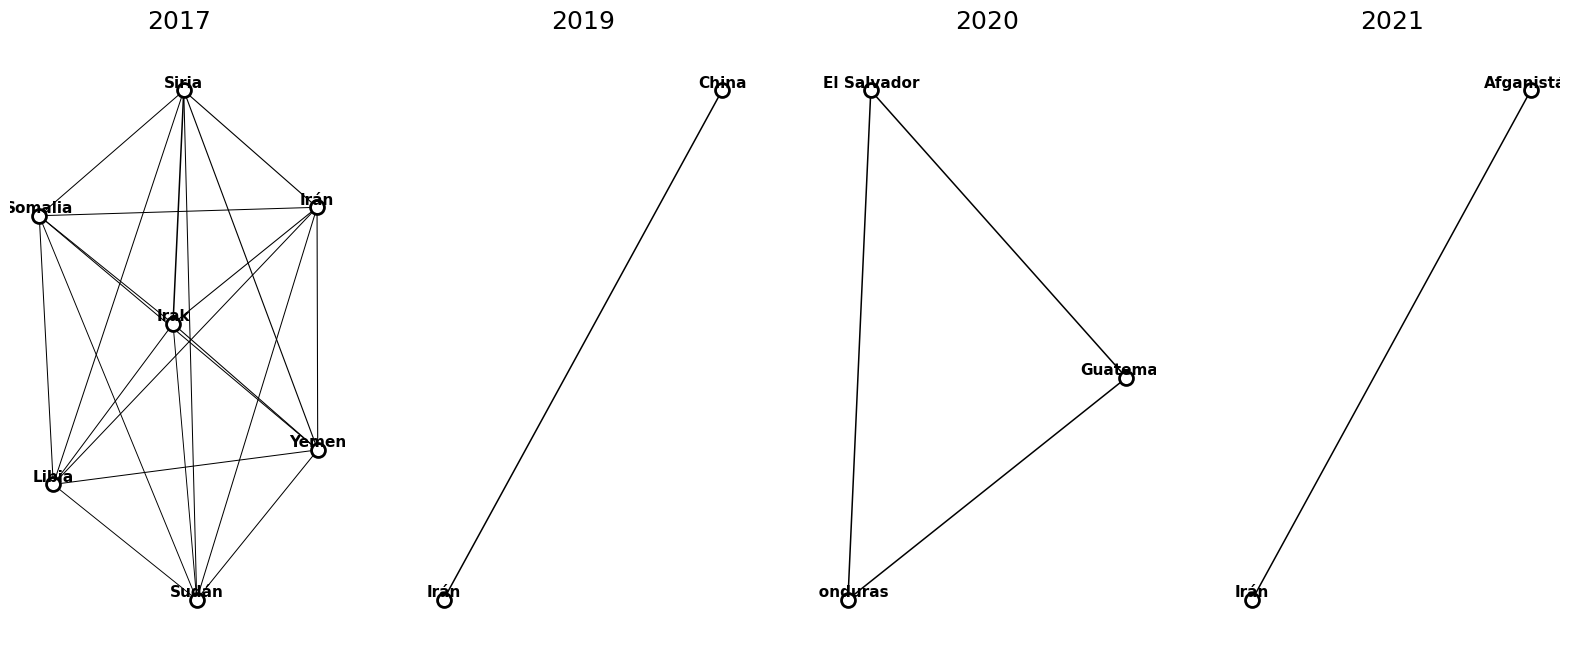

In [438]:
fig, axs = plt.subplots(figsize=(20,8), facecolor="w", nrows=1, ncols=4)
k = 0
for year in [2017,2019,2020,2021]:
    
    df_date = dataset[dataset['date'].dt.year == year][['id_news','pais']]
    
    G = nx.Graph()

    for _, row in df_date.iterrows():
        paises = row['pais']
        for i in range(len(paises)):
            for j in range(i + 1, len(paises)):
                peso = G.get_edge_data(paises[i], paises[j], default={'weight': 0})['weight'] + 1
                G.add_edge(paises[i], paises[j], weight=peso)
                
    G_map = nx.Graph()
    weights = nx.get_edge_attributes(G, "weight")

    edges = heapq.nlargest(1000, weights.items(), key=lambda x: x[1])
    for edge, weight in edges:
        pais1, pais2 = edge
        distancia = geodesic((coordenadas[pais2][0], coordenadas[pais2][1]), (coordenadas[pais1][0], coordenadas[pais1][1])).kilometers
    
        if distancia < 5000 and weight>5 :
            G_map.add_edge(pais1, pais2, weight=weight)
    comunidades = nx.community.louvain_communities(G_map, seed=123)
    grupos = {}

    for i, comunidad in enumerate(comunidades):
        for nodo in comunidad:
            grupos[nodo] = i
        
    subgrafos = []
    for comunidad in comunidades:
        subgrafo = G_map.subgraph(comunidad)
        subgrafos.append(subgrafo)
        
    graph = 2

    if year == 2019:
        graph = 3
        
    if year == 2021:
        graph = 3
    
    pos = nx.layout.circular_layout(subgrafos[graph])
    pos = nx.spring_layout(subgrafos[graph], pos=pos, k=0.7, iterations=300, seed=0)
    
    
    nx.draw_networkx_nodes(subgrafos[graph], pos, node_color='white', linewidths=2, 
      edgecolors='k', ax=axs[k], node_size=100)
    labels = nx.get_edge_attributes(subgrafos[graph], 'weight')
    weights = list(labels.values())
    normalized_weights = [(weight /  max(weights))+0.1 for weight in weights]
    nx.draw_networkx_edges(subgrafos[graph], pos, width=normalized_weights, ax=axs[k])
    nx.draw_networkx_labels(subgrafos[graph], pos, font_size=11, font_weight='bold',verticalalignment='bottom', ax=axs[k])
    axs[k].spines[['left', 'right', 'top', 'bottom']].set_visible(False)
    axs[k].set_title("${%i}$" % (year), fontsize=18)
    k = k+1

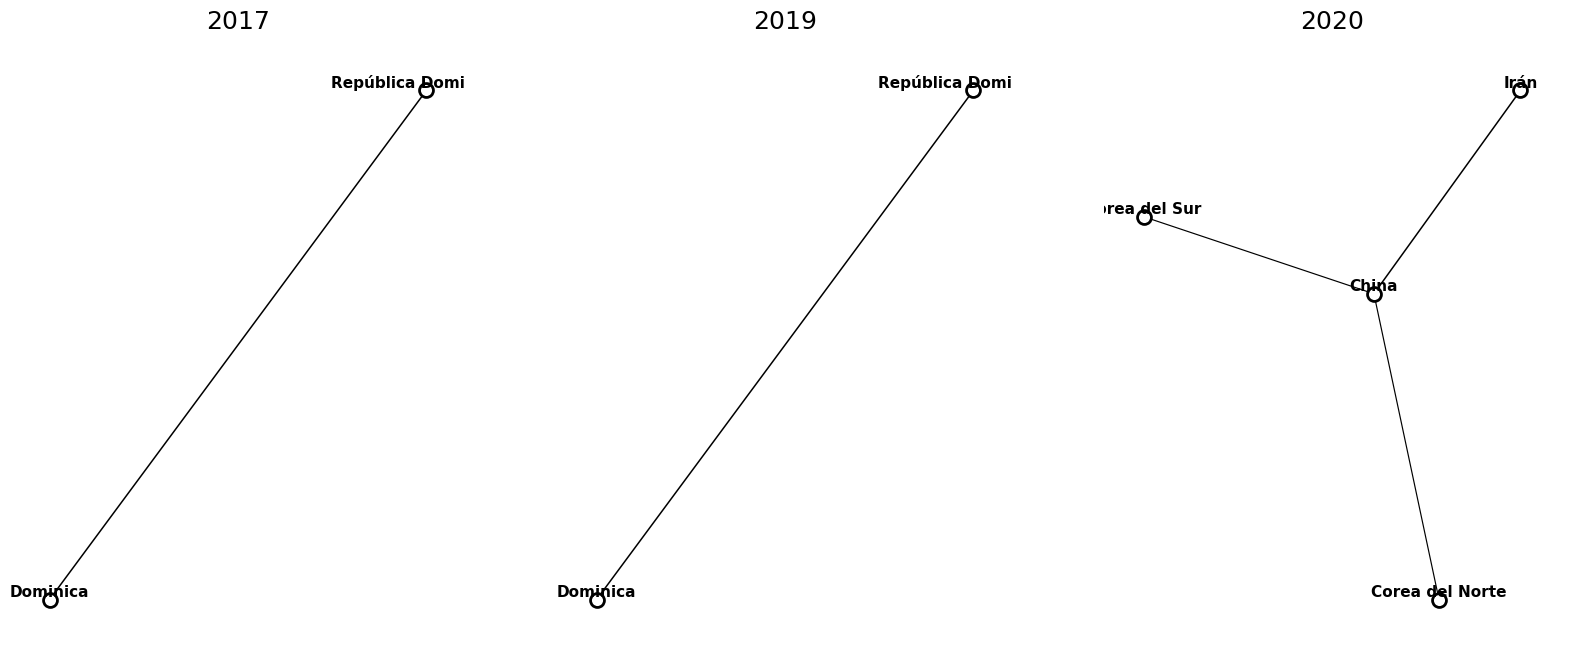

In [439]:
fig, axs = plt.subplots(figsize=(20,8), facecolor="w", nrows=1, ncols=3)
k = 0
for year in [2017,2019,2020]:
    
    df_date = dataset[dataset['date'].dt.year == year][['id_news','pais']]
    
    G = nx.Graph()

    for _, row in df_date.iterrows():
        paises = row['pais']
        for i in range(len(paises)):
            for j in range(i + 1, len(paises)):
                peso = G.get_edge_data(paises[i], paises[j], default={'weight': 0})['weight'] + 1
                G.add_edge(paises[i], paises[j], weight=peso)
                
    G_map = nx.Graph()
    weights = nx.get_edge_attributes(G, "weight")
    edges = heapq.nlargest(1000, weights.items(), key=lambda x: x[1])
    for edge, weight in edges:
        pais1, pais2 = edge
        distancia = geodesic((coordenadas[pais2][0], coordenadas[pais2][1]), (coordenadas[pais1][0], coordenadas[pais1][1])).kilometers
    
        if distancia < 5000 and weight>5 :
            G_map.add_edge(pais1, pais2, weight=weight)

    comunidades = nx.community.louvain_communities(G_map, seed=123)
    grupos = {}

    for i, comunidad in enumerate(comunidades):
        for nodo in comunidad:
            grupos[nodo] = i
        
    subgrafos = []
    for comunidad in comunidades:
        subgrafo = G_map.subgraph(comunidad)
        subgrafos.append(subgrafo)
        
    graph = 4
    pos = nx.layout.circular_layout(subgrafos[graph])
    pos = nx.spring_layout(subgrafos[graph], pos=pos, k=0.7, iterations=300, seed=0)
    nx.draw_networkx_nodes(subgrafos[graph], pos, node_color='white', linewidths=2, 
      edgecolors='k', ax=axs[k], node_size=100)
    labels = nx.get_edge_attributes(subgrafos[graph], 'weight')
    weights = list(labels.values())
    normalized_weights = [(weight /  max(weights))+0.1 for weight in weights]
    nx.draw_networkx_edges(subgrafos[graph], pos, width=normalized_weights, ax=axs[k])
  
    nx.draw_networkx_labels(subgrafos[graph], pos, font_size=11, font_weight='bold',verticalalignment='bottom', ax=axs[k])
    axs[k].spines[['left', 'right', 'top', 'bottom']].set_visible(False)
    axs[k].set_title("${%i}$" % (year), fontsize=18)
    k = k+1